In [1]:
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.pipeline import Pipeline, clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, roc_curve
from xgboost import XGBClassifier
import pandas as pd
import itertools
import numpy as np
import pandas as pd
import pickle
import os
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import ast  # For safely converting string to list if needed
import itertools
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import pandas as pd
import numpy as np
import itertools
import pickle
import time
import logging

from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, roc_auc_score
)
from xgboost import XGBClassifier

/home/sxa1953/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cleaned_df = pd.read_csv('cleaned_df_severe_outcome.csv', low_memory=False)

categorical_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'severe_outcome','gender', 'nyhac2']
numerical_cols = ['age', 'bmi', 'hr', 'sbp', 'lvef','creat']

In [ ]:
# === Configuration ===
checkpoint_csv = "XGB_results_checkpoint.csv"
roc_data_pickle = "XGB_roc_data_checkpoint.pkl"
save_every_n_studies = 1  # frequency to save results
trial_run = False  # <--- Set to False to run full
max_test_studies = 2 if trial_run else None
max_combo_size = 2 if trial_run else None

# === Preprocessing ===
drop_cols = ['severe_outcome', 'study', 'upid']
target_col = 'severe_outcome'

preprocessor = ColumnTransformer(transformers=[
    ('qt', QuantileTransformer(output_distribution='normal', random_state=42),
     ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']),
], remainder='passthrough')

xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(random_state=42))
])

xgb_param_grid = {
    'clf__learning_rate': [0.001, 0.005, 0.01, 0.05],
    'clf__max_depth': [2, 3, 4],
    'clf__n_estimators': [800, 1000, 2000],
    'clf__subsample': [0.5, 0.9],
    'clf__colsample_bytree': [0.5, 0.6, 0.7, 0.85, 0.9, 1],
    'clf__min_child_weight': [4, 5, 6, 7, 8],
    'clf__gamma': [0.03, 0.05, 0.07],
    'clf__reg_alpha': [0.1, 0.2, 0.25, 0.3, 0.4],
    'clf__tree_method': ['hist'],
    'clf__eval_metric': ['auc']
}

# === Logging Setup ===
logging.basicConfig(filename='xgb_brute_force.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# === Initializations ===
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
roc_data = {}
done_combos = set()

# === Load Data ===
# Ensure cleaned_df is defined before this point
all_rcts = cleaned_df['study'].unique()
if trial_run:
    all_rcts = all_rcts[:max_test_studies]

# === Brute-Force Search ===
for test_idx, test_study in enumerate(tqdm(all_rcts, desc="Test studies")):
    best_auc = -np.inf
    best_combo = None
    best_y_test = None
    best_y_proba = None
    best_y_pred = None
    best_internal_cv_auc = None

    train_studies = [r for r in all_rcts if r != test_study]

    for k in tqdm(range(1, len(train_studies) + 1), desc=f"Train combos for {test_study}", leave=False):
        if trial_run and k > max_combo_size:
            continue

        for combo in itertools.combinations(train_studies, k):
            if (test_study, combo) in done_combos:
                continue

            train_subset = cleaned_df[cleaned_df['study'].isin(combo)]
            test_subset = cleaned_df[cleaned_df['study'] == test_study]

            X_train = train_subset.drop(columns=drop_cols)
            y_train = train_subset[target_col]
            X_test = test_subset.drop(columns=drop_cols)
            y_test = test_subset[target_col]

            if len(np.unique(y_test)) < 2:
                continue

            try:
                start_time = time.time()
                search = RandomizedSearchCV(
                    estimator=xgb_pipeline,
                    param_distributions=xgb_param_grid,
                    scoring='roc_auc',
                    refit=True,
                    cv=cv_strategy,
                    verbose=0,
                    n_jobs=-1,
                    n_iter=10,
                    random_state=42
                )

                search.fit(X_train, y_train)
                elapsed = time.time() - start_time

                best_model = search.best_estimator_
                cv_auc_mean = search.cv_results_['mean_test_score'][search.best_index_]

                y_pred = best_model.predict(X_test)
                y_proba = best_model.predict_proba(X_test)[:, 1]

                acc = accuracy_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_proba)

                result_entry = {
                    'Test Study': test_study,
                    'Train Studies': combo,
                    'Num Train Studies': len(combo),
                    'Accuracy': acc,
                    'Recall': recall,
                    'Precision': precision,
                    'F1 Score': f1,
                    'ROC AUC': roc_auc,
                    'y_test': y_test.values.tolist(),
                    'y_pred': y_pred.tolist(),
                    'y_proba': y_proba.tolist(),
                    'Best Params': search.best_params_,
                    'internal_auc': cv_auc_mean,
                }

                results.append(result_entry)
                done_combos.add((test_study, combo))

                if roc_auc > best_auc:
                    best_auc = roc_auc
                    best_combo = combo
                    best_y_test = y_test.values
                    best_y_proba = y_proba
                    best_y_pred = y_pred
                    best_internal_cv_auc = cv_auc_mean

            except Exception as e:
                logging.warning(f"Failed on combo {combo} for test {test_study}: {e}")
                continue

    if best_combo is not None:
        roc_data[test_study] = {
            'y_test': best_y_test.tolist(),
            'y_proba': best_y_proba.tolist(),
            'y_pred': best_y_pred.tolist(),
            'best_combo': best_combo,
            'best_auc': best_auc,
            'internal_cv_auc': best_internal_cv_auc
        }

    if (test_idx + 1) % save_every_n_studies == 0:
        pd.DataFrame(results).to_csv(checkpoint_csv, index=False)
        with open(roc_data_pickle, 'wb') as f:
            pickle.dump(roc_data, f)
        logging.info(f"[Checkpoint] Saved after test study: {test_study}")

# === Final Save ===
pd.DataFrame(results).to_csv("XGB_results_LOSO_final.csv", index=False)
with open("XGB_roc_data_final.pkl", 'wb') as f:
    pickle.dump(roc_data, f)

logging.info("✅ Final results saved successfully.")

Train combos for MDC:   0%|          | 0/8 [00:00<?, ?it/s]/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (821). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (821). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (822). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (822). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/pre

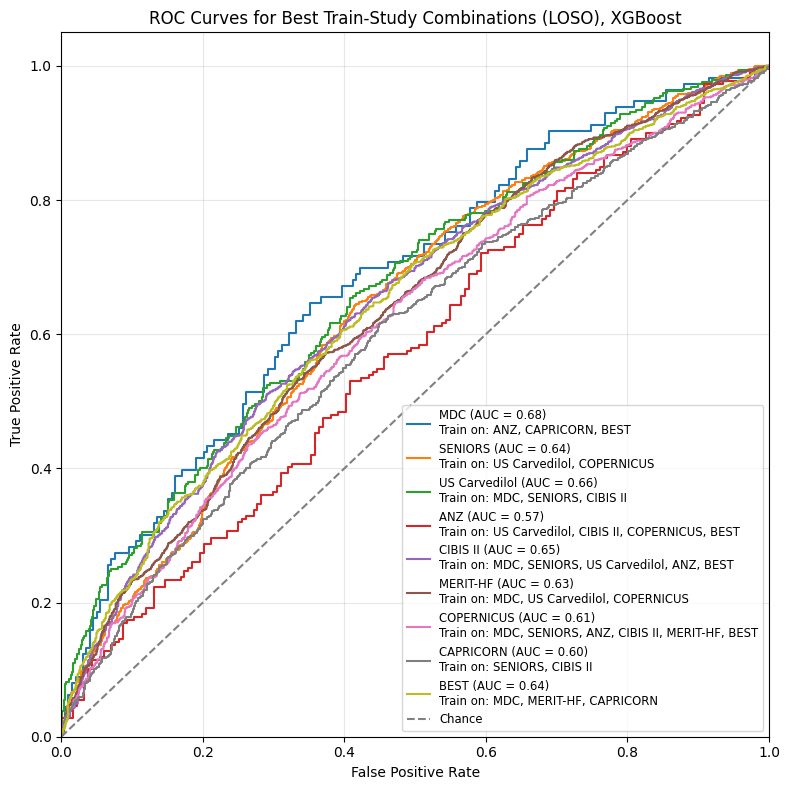

In [114]:
# LOSO, best combinations, all

results_df = pd.read_csv('XGB_results_LOSO_final.csv')  # if not already loaded

# Sort the DataFrame by ROC AUC in descending order
sorted_df = results_df.sort_values(by='ROC AUC', ascending=False)

# Drop duplicates to keep only the top ROC AUC row per Test Study
top_per_test_study = sorted_df.drop_duplicates(subset='Test Study', keep='first').reset_index(drop=True)

# Optional: display key columns
cols_to_show = ['Test Study', 'Train Studies', 'Accuracy', 'ROC AUC', 'F1 Score', 'internal_auc']
top_per_test_study = top_per_test_study[cols_to_show].round(3)
top_per_test_study.to_csv("results df/XGB_top_per_test_study_final.csv", index=False)


# Plot ROC curves for each test study
plt.figure(figsize=(8, 8))

for study, data in roc_data.items():
    fpr, tpr, _ = roc_curve(data['y_test'], data['y_proba'])
    roc_auc = auc(fpr, tpr)
    train_label = ", ".join(data['best_combo'])
    plt.plot(fpr, tpr, label=f"{study} (AUC = {roc_auc:.2f})\nTrain on: {train_label}")

# Plot chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')

# Style
plt.title("ROC Curves for Best Train-Study Combinations (LOSO), XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='small', frameon=True)

plt.tight_layout()
plt.savefig("graphs/model results plot/XGB_roc_curves_best_loso_all_comb.png", dpi=300)
plt.show()

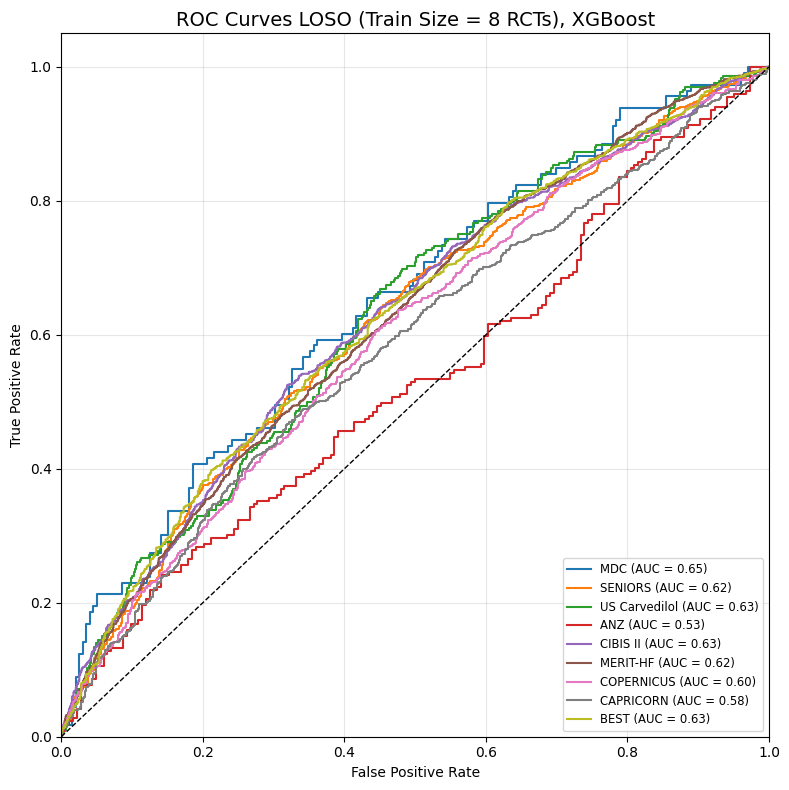

In [122]:
# LOSO, train on 8, test on 1


# Filter for LOSO with 8 training studies
loso_results_df = results_df[results_df['Num Train Studies'] == 8]
loso_results_df[cols_to_show]

plt.figure(figsize=(8, 8))
auc_list = []

for i, row in loso_results_df.iterrows():
    test_study = row['Test Study']
    
    # Convert from string to list if stored as string
    y_test = row['y_test']
    y_proba = row['y_proba']

    if isinstance(y_test, str):
        y_test = ast.literal_eval(y_test)
    if isinstance(y_proba, str):
        y_proba = ast.literal_eval(y_proba)

    y_test = np.array(y_test)
    y_proba = np.array(y_proba)

    # Skip if y_test doesn't have both classes
    if len(np.unique(y_test)) < 2:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    auc_list.append(roc_auc)

    plt.plot(fpr, tpr, label=f"{test_study} (AUC = {roc_auc:.2f})")

# Reference line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Aesthetics
plt.title('ROC Curves LOSO (Train Size = 8 RCTs), XGBoost', fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='small', frameon=True)
plt.tight_layout()
plt.savefig("graphs/model results plot/XGB_roc_curves_best_loso_8_train.png", dpi=300)
plt.show()


=== Training on study: MDC ===


/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (249). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (249). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (250). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (250). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) i

 - Accuracy: 0.5885
 - ROC AUC:  0.6000
 - F1 Score: 0.4768

=== Training on study: SENIORS ===
 - Accuracy: 0.5915
 - ROC AUC:  0.6062
 - F1 Score: 0.4792

=== Training on study: US Carvedilol ===


/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (821). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (822). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (821). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (822). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) i

 - Accuracy: 0.5447
 - ROC AUC:  0.6081
 - F1 Score: 0.0003

=== Training on study: ANZ ===


/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (322). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (322). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (322). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (323). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) i

 - Accuracy: 0.4820
 - ROC AUC:  0.5374
 - F1 Score: 0.5894

=== Training on study: CIBIS II ===
 - Accuracy: 0.5839
 - ROC AUC:  0.6037
 - F1 Score: 0.5058

=== Training on study: MERIT-HF ===
 - Accuracy: 0.5697
 - ROC AUC:  0.6048
 - F1 Score: 0.3429

=== Training on study: COPERNICUS ===
 - Accuracy: 0.5655
 - ROC AUC:  0.6219
 - F1 Score: 0.1253

=== Training on study: CAPRICORN ===
 - Accuracy: 0.5096
 - ROC AUC:  0.6142
 - F1 Score: 0.6127

=== Training on study: BEST ===
 - Accuracy: 0.4383
 - ROC AUC:  0.5856
 - F1 Score: 0.5663

=== Summary of Reverse LOSO (Train-One, Test-All-Others) ===
  training_study  accuracy  roc_auc  f1_score  \
0            MDC     0.589    0.600     0.477   
1        SENIORS     0.591    0.606     0.479   
2  US Carvedilol     0.545    0.608     0.000   
3            ANZ     0.482    0.537     0.589   
4       CIBIS II     0.584    0.604     0.506   
5       MERIT-HF     0.570    0.605     0.343   
6     COPERNICUS     0.565    0.622     0.125   
7 

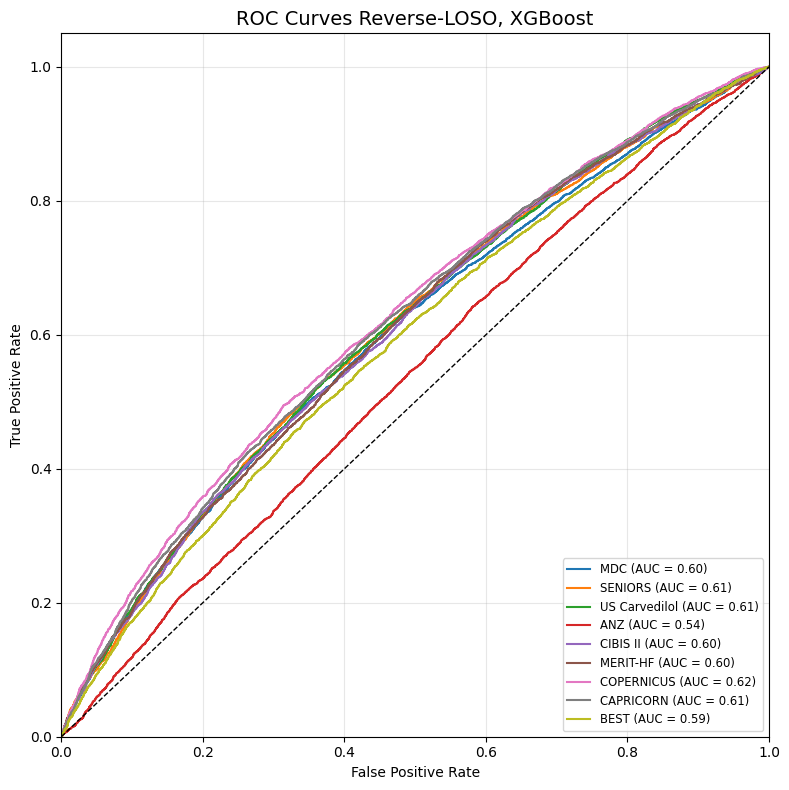

In [6]:
# Reverse the validation direction – Try training on one RCT and testing on all the others.


# === Setup ===
reverse_results = []
reverse_roc_data = {}
unique_studies = cleaned_df['study'].unique()

drop_cols = ['severe_outcome', 'study', 'upid']
target_col = 'severe_outcome'

# Define preprocessing and model
preprocessor = ColumnTransformer(transformers=[
    ('qt', QuantileTransformer(output_distribution='normal', random_state=42),
     ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']),
], remainder='passthrough')

xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(random_state=42))
])

xgb_param_grid = {
    'clf__learning_rate': [0.001, 0.005, 0.01, 0.05],
    'clf__max_depth': [2, 3, 4],
    'clf__n_estimators': [800, 1000, 2000],
    'clf__subsample': [0.5, 0.9],
    'clf__colsample_bytree': [0.5, 0.6, 0.7, 0.85, 0.9, 1],
    'clf__min_child_weight': [4, 5, 6, 7, 8],
    'clf__gamma': [0.03, 0.05, 0.07],
    'clf__reg_alpha': [0.1, 0.2, 0.25, 0.3, 0.4],
    'clf__tree_method': ['hist'],
    'clf__eval_metric': ['auc']
}

# === Loop over all unique RCTs ===
for training_rct in unique_studies:
    print(f"\n=== Training on study: {training_rct} ===")

    train_df = cleaned_df[cleaned_df['study'] == training_rct]
    test_df = cleaned_df[cleaned_df['study'] != training_rct]

    X_train = train_df.drop(columns=drop_cols)
    y_train = train_df['severe_outcome']
    X_test = test_df.drop(columns=drop_cols)
    y_test = test_df['severe_outcome']

    grid = RandomizedSearchCV(
        estimator=xgb_pipeline,
        param_distributions=xgb_param_grid,
        scoring='roc_auc',
        refit=True,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        verbose=0,
        n_jobs=-1,
        n_iter=10,
        random_state=42
    )

    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]
    cv_auc_mean = grid.cv_results_['mean_test_score'][grid.best_index_]

    acc = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)


    print(f" - Accuracy: {acc:.4f}")
    print(f" - ROC AUC:  {auc_score:.4f}")
    print(f" - F1 Score: {f1:.4f}")

    reverse_results.append({
        'training_study': training_rct,
        'accuracy': acc,
        'roc_auc': auc_score,
        'f1_score': f1,
        'best_params': grid.best_params_,
        'n_test': len(y_test),
        'n_train': len(y_train),
        'internal_auc': cv_auc_mean
    })

    reverse_roc_data[training_rct] = {
        'y_test': y_test.values,
        'y_proba': y_proba
    }

# === Save and Summarize ===
reverse_df = pd.DataFrame(reverse_results)

print("\n=== Summary of Reverse LOSO (Train-One, Test-All-Others) ===")
print(reverse_df.round(3))

# === Weighted Metrics ===
weighted_auc = (reverse_df['roc_auc'] * reverse_df['n_test']).sum() / reverse_df['n_test'].sum()
weighted_acc = (reverse_df['accuracy'] * reverse_df['n_test']).sum() / reverse_df['n_test'].sum()
weighted_f1 = (reverse_df['f1_score'] * reverse_df['n_test']).sum() / reverse_df['n_test'].sum()

print(f"\nWeighted ROC AUC: {weighted_auc:.4f}")
print(f"Weighted Accuracy: {weighted_acc:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# === Plot ROC Curves ===
plt.figure(figsize=(8, 8))
for study, data in reverse_roc_data.items():
    fpr, tpr, _ = roc_curve(data['y_test'], data['y_proba'])
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{study} (AUC = {auc_val:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC Curves Reverse-LOSO, XGBoost', fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='small', frameon=True)
plt.tight_layout()
#plt.savefig("graphs/model results plot/XGB_roc_curves_reverse_loso.png", dpi=300)
plt.show()

In [130]:
print("all loso results")
top_per_test_study

all loso results


,Test Study,Train Studies,Accuracy,ROC AUC,F1 Score,internal_auc
0,MDC,"('ANZ', 'CAPRICORN', 'BEST')",0.433,0.678,0.552,0.681
1,US Carvedilol,"('MDC', 'SENIORS', 'CIBIS II')",0.620,0.664,0.466,0.649
2,CIBIS II,"('MDC', 'SENIORS', 'US Carvedilol', 'ANZ', 'BE...",0.505,0.646,0.594,0.683
3,BEST,"('MDC', 'MERIT-HF', 'CAPRICORN')",0.464,0.642,0.438,0.617
4,SENIORS,"('US Carvedilol', 'COPERNICUS')",0.570,0.641,0.048,0.629
5,MERIT-HF,"('MDC', 'US Carvedilol', 'COPERNICUS')",0.653,0.634,0.052,0.635
6,COPERNICUS,"('MDC', 'SENIORS', 'ANZ', 'CIBIS II', 'MERIT-H...",0.513,0.615,0.571,0.677
7,CAPRICORN,"('SENIORS', 'CIBIS II')",0.574,0.599,0.264,0.649
8,ANZ,"('US Carvedilol', 'CIBIS II', 'COPERNICUS', 'B...",0.494,0.574,0.197,0.670


In [132]:
print("reverese loso results")
reverse_df.round(3)

reverese loso results


,training_study,accuracy,roc_auc,f1_score,best_params,n_test,n_train,internal_auc
0,MDC,0.589,0.600,0.477,"{'clf__tree_method': 'hist', 'clf__subsample':...",15841,312,0.680
1,SENIORS,0.591,0.606,0.479,"{'clf__tree_method': 'hist', 'clf__subsample':...",14486,1667,0.644
2,US Carvedilol,0.545,0.608,0.000,"{'clf__tree_method': 'hist', 'clf__subsample':...",15126,1027,0.643
3,ANZ,0.482,0.537,0.589,"{'clf__tree_method': 'hist', 'clf__subsample':...",15750,403,0.471
4,CIBIS II,0.584,0.604,0.506,"{'clf__tree_method': 'hist', 'clf__subsample':...",13670,2483,0.650
5,MERIT-HF,0.570,0.605,0.343,"{'clf__tree_method': 'hist', 'clf__subsample':...",12295,3858,0.635
6,COPERNICUS,0.565,0.622,0.125,"{'clf__tree_method': 'hist', 'clf__subsample':...",14046,2107,0.618
7,CAPRICORN,0.510,0.614,0.613,"{'clf__tree_method': 'hist', 'clf__subsample':...",14412,1741,0.604
8,BEST,0.438,0.586,0.566,"{'clf__tree_method': 'hist', 'clf__subsample':...",13598,2555,0.638


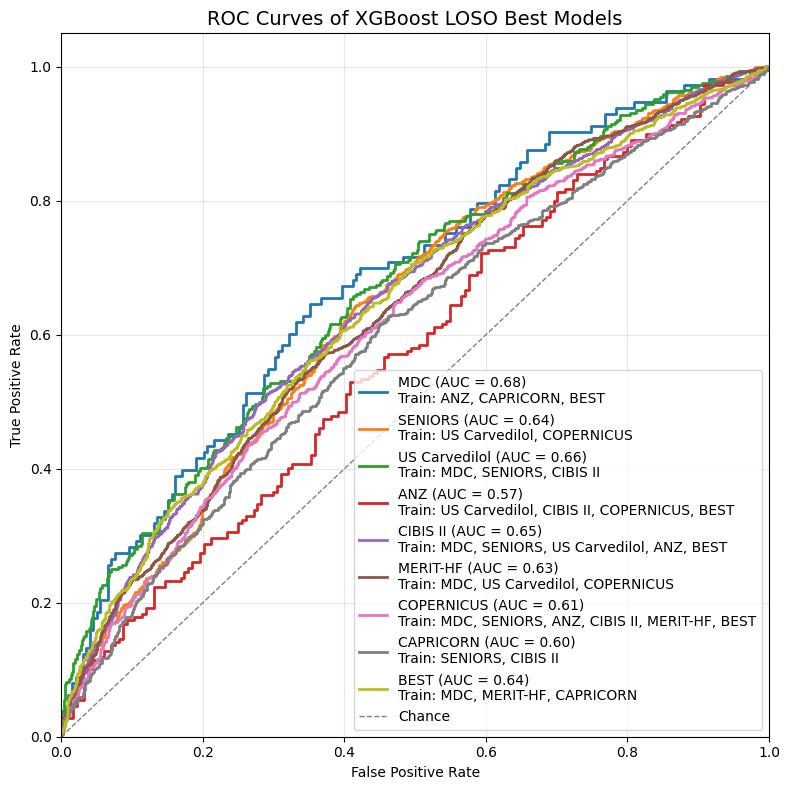

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import ast
import pickle

# Your custom order to maintain consistency in plots
custom_order = [
    "MDC", "SENIORS", "US Carvedilol", "ANZ", "CIBIS II",
    "MERIT-HF", "COPERNICUS", "CAPRICORN", "BEST"
]

# --- Load results and ROC data ---
results_df = pd.read_csv("results df/LOSO/XGB_results_LOSO_final.csv")
with open("XGB_roc_data_final.pkl", 'rb') as f:
    roc_data = pickle.load(f)

# --- Extract best results per test study ---
best_rows = []
for test_study, group in results_df.groupby('Test Study'):
    # Find row with max ROC AUC in group
    best_row = group.loc[group['ROC AUC'].idxmax()]
    # Add fpr, tpr computed from roc_data pickle
    if test_study in roc_data:
        y_test = np.array(roc_data[test_study]['y_test'])
        y_proba = np.array(roc_data[test_study]['y_proba'])
        if len(np.unique(y_test)) >= 2:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            best_row = best_row.copy()
            best_row['fpr'] = fpr
            best_row['tpr'] = tpr
            best_row['computed_auc'] = roc_auc
            best_rows.append(best_row)
        else:
            print(f"Skipping {test_study} due to insufficient positive class in y_test")
    else:
        print(f"No ROC data found for {test_study}")

# Sort by your custom order for consistent plotting
best_rows_sorted = sorted(
    best_rows,
    key=lambda r: custom_order.index(r['Test Study']) if r['Test Study'] in custom_order else 999
)

# --- Plotting ---
plt.figure(figsize=(8, 8))
for row in best_rows_sorted:
    test_study = row['Test Study']
    auc_score = row['computed_auc']
    fpr = row['fpr']
    tpr = row['tpr']

    # Format training combo nicely
    train_combo = row['Train Studies']
    if isinstance(train_combo, str):
        try:
            train_combo = ast.literal_eval(train_combo)
        except Exception:
            pass
    if isinstance(train_combo, (list, tuple)):
        train_label = ", ".join(train_combo)
    else:
        train_label = str(train_combo)

    plt.plot(fpr, tpr, lw=2,
             label=f"{test_study} (AUC = {auc_score:.2f})\nTrain: {train_label}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Chance')
plt.title('ROC Curves of XGBoost LOTO Best Models', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='medium', frameon=True)
plt.tight_layout()
plt.savefig("graphs/model results plot/XGB_roc_curves_best_auc_ordered.pdf", dpi=600, format='pdf')
plt.show()


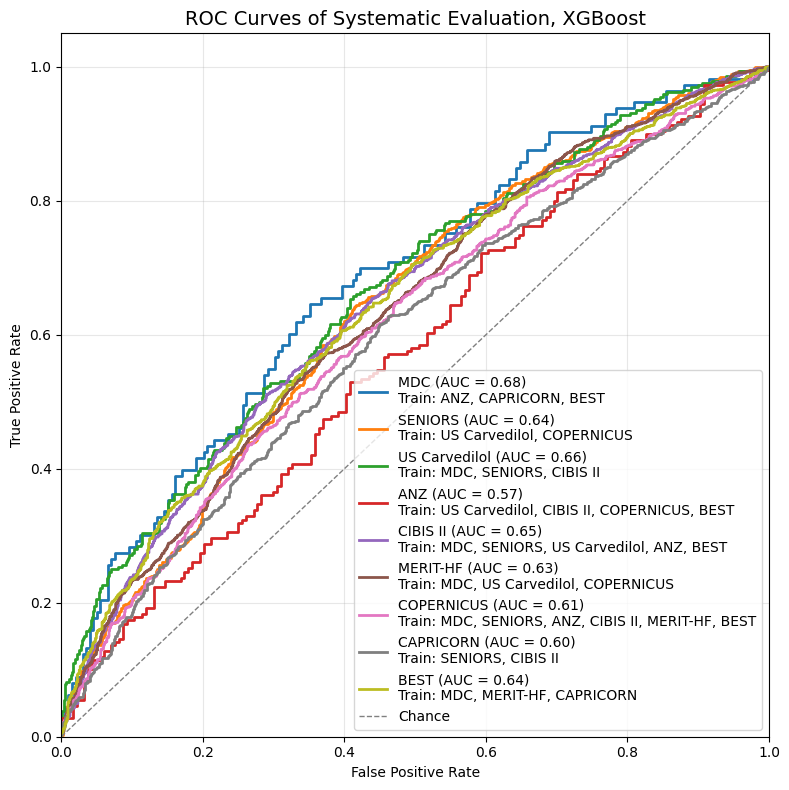

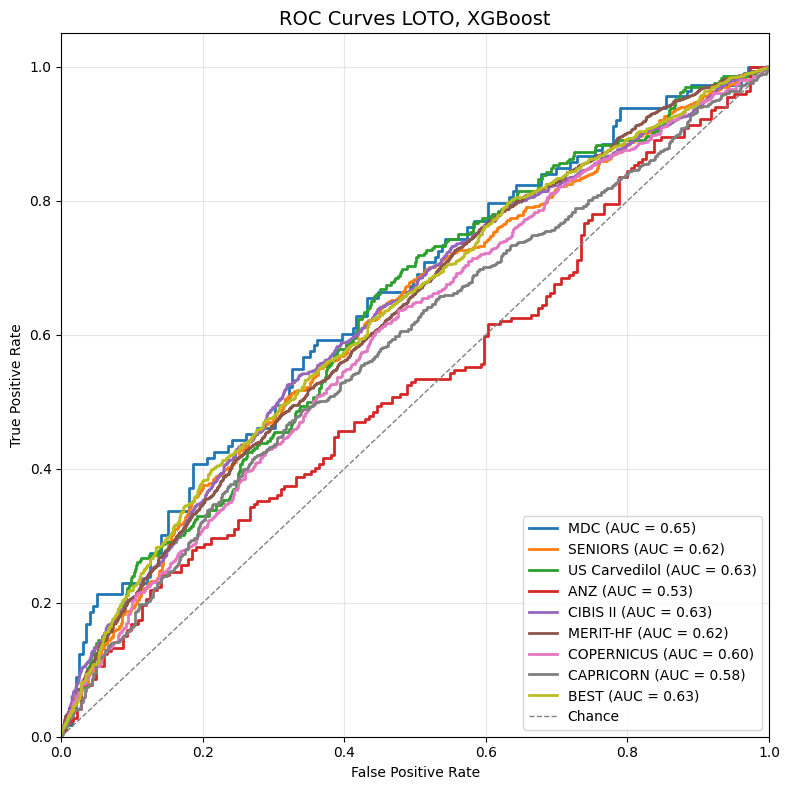

No reverse ROC data found for XGB. Skipping reverse LOSO plot.


In [8]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Use your same custom order for consistency
custom_order = [
    "MDC", "SENIORS", "US Carvedilol", "ANZ", "CIBIS II",
    "MERIT-HF", "COPERNICUS", "CAPRICORN", "BEST"
]

# Load your saved XGB results and ROC data
results_df = pd.read_csv("results df/LOSO/XGB_results_LOSO_final.csv")
with open("XGB_roc_data_final.pkl", "rb") as f:
    roc_data = pickle.load(f)

# === 1) Plot Best ROC Curves from all combos with train labels ===
best_rows = []
for test_study, group in results_df.groupby('Test Study'):
    max_auc = -1
    best_row = None
    for _, row in group.iterrows():
        if row['ROC AUC'] > max_auc:
            max_auc = row['ROC AUC']
            best_row = row
    if best_row is not None:
        best_rows.append(best_row)

# Sort by custom order
best_rows_sorted = sorted(
    best_rows,
    key=lambda r: custom_order.index(r['Test Study']) if r['Test Study'] in custom_order else 999
)

plt.figure(figsize=(8, 8))
for row in best_rows_sorted:
    y_test = np.array(ast.literal_eval(row['y_test'])) if isinstance(row['y_test'], str) else np.array(row['y_test'])
    y_proba = np.array(ast.literal_eval(row['y_proba'])) if isinstance(row['y_proba'], str) else np.array(row['y_proba'])
    if len(np.unique(y_test)) < 2:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    # Prepare train label string from tuple/list
    if isinstance(row['Train Studies'], str):
        try:
            train_label = ", ".join(ast.literal_eval(row['Train Studies']))
        except Exception:
            train_label = str(row['Train Studies'])
    else:
        train_label = str(row['Train Studies'])

    plt.plot(fpr, tpr, lw=2,
             label=f"{row['Test Study']} (AUC = {roc_auc:.2f})\nTrain: {train_label}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Chance')
plt.title('ROC Curves of Systematic Evaluation, XGBoost', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='medium', frameon=True)
plt.tight_layout()
plt.savefig("graphs/model results plot/XGB_roc_curves_best_all_train_labels.pdf", dpi=600)
plt.show()

# === 2) Plot Best ROC Curves trained on exactly 8 studies (no train labels) ===
# Filter rows with exactly 8 training studies
train_8_df = results_df[results_df['Num Train Studies'] == 8]

best_rows_8 = []
for test_study, group in train_8_df.groupby('Test Study'):
    max_auc = -1
    best_row = None
    for _, row in group.iterrows():
        if row['ROC AUC'] > max_auc:
            max_auc = row['ROC AUC']
            best_row = row
    if best_row is not None:
        best_rows_8.append(best_row)

best_rows_8_sorted = sorted(
    best_rows_8,
    key=lambda r: custom_order.index(r['Test Study']) if r['Test Study'] in custom_order else 999
)

plt.figure(figsize=(8, 8))
for row in best_rows_8_sorted:
    y_test = np.array(ast.literal_eval(row['y_test'])) if isinstance(row['y_test'], str) else np.array(row['y_test'])
    y_proba = np.array(ast.literal_eval(row['y_proba'])) if isinstance(row['y_proba'], str) else np.array(row['y_proba'])
    if len(np.unique(y_test)) < 2:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f"{row['Test Study']} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Chance')
plt.title('ROC Curves LOTO, XGBoost', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='medium', frameon=True)
plt.tight_layout()
plt.savefig("graphs/model results plot/XGB_roc_curves_loso_train8_no_train_labels.pdf", dpi=600)
plt.show()

# === 3) Plot Reverse LOSO ROC Curves ===
# Assuming you have a dictionary `reverse_roc_data_xgb` structured similarly to `reverse_roc_data`
# { 'MDC': {'y_test': [...], 'y_proba': [...]}, ... }

if 'reverse_roc_data_xgb' in globals():
    ordered_items = [(study, reverse_roc_data_xgb[study]) for study in custom_order if study in reverse_roc_data_xgb]

    plt.figure(figsize=(8, 8))
    for study, data in ordered_items:
        y_test = np.array(data['y_test'])
        y_proba = np.array(data['y_proba'])
        if len(np.unique(y_test)) < 2:
            continue
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{study} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Chance')
    plt.title('ROC Curves Reverse-LOTO, XGBoost', fontsize=14)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(alpha=0.3)
    plt.legend(loc='lower right', fontsize='medium', frameon=True)
    plt.tight_layout()
    plt.savefig("graphs/model results plot/XGB_roc_curves_reverse_loso.pdf", dpi=600)
    plt.show()
else:
    print("No reverse ROC data found for XGB. Skipping reverse LOSO plot.")


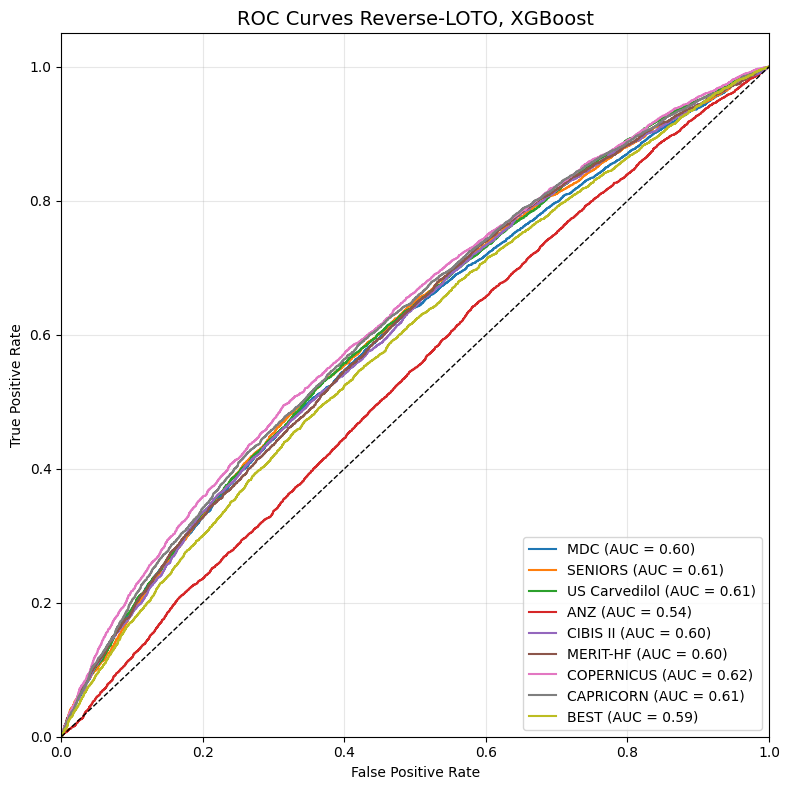

In [10]:
# === Plot ROC Curves ===
plt.figure(figsize=(8, 8))
for study, data in reverse_roc_data.items():
    fpr, tpr, _ = roc_curve(data['y_test'], data['y_proba'])
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{study} (AUC = {auc_val:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC Curves Reverse-LOTO, XGBoost', fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='medium', frameon=True)
plt.tight_layout()
plt.savefig("graphs/model results plot/XGB_roc_curves_reverse_loso.pdf", dpi=600)
plt.show()